<a href="https://colab.research.google.com/github/KrzysztofLin/Superhero_text_mining/blob/main/superheores_text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor programu, jako środowiska korzystał z środowiska "Google Colab", aby uruchomić program w Jupyter Notebooku wymagane jest podanie ścieżki do pliku zawierajacego dane.

Program's author as IDE used "Google Colab". To run program in Jupyter Notebook please choose a directory to file placed in folder named "data".

In [48]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/Text_minning/zad3_superheroes

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Text_minning/zad3_superheroes


#0. Basic data preprocessing for further analysis


Upload/installation of the nessesary libraries.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import List
from sklearn import svm, datasets
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import warnings
warnings.simplefilter("ignore", UserWarning)

Data load and

In [50]:
raw_data = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Text_minning/zad3_superheroes/superheroes.xlsx')

Process the data into a form that facilitates further work. The following steps are performed:  
- converting missing data into whitespace characters, 
- merging the 'powers_text' and 'history_text' columns,
- selection of columns to work with,
- replace empty rows with NaN rows,
- changing incorrect row values in 'creator' column to NaN rows,
- removing missing data,
- replace observations other than DC and Marvel Comics with 'other creator'.


In [51]:
def early_data_preprocessing(raw_data: pd.DataFrame, choosen_parameters_names: List[str]) -> pd.DataFrame:
  raw_data = raw_data.fillna('')
  raw_data['description'] = raw_data['powers_text'] + raw_data['history_text']
  raw_data = raw_data[choosen_parameters_names]
  raw_data = raw_data.replace(r'', float('NaN'), regex = True)
  raw_data['creator'] = raw_data['creator'].replace(r'[0-9]\.0', float('NaN'), regex = True)
  raw_data.dropna(inplace = True)
  
  names_to_replace = set(raw_data['creator']) - {'Marvel Comics', 'DC Comics'}
  raw_data['creator']= raw_data['creator'].replace(to_replace=names_to_replace, value='other creator')
  return raw_data

#1. Functions and classes to perform search for optimal hyperparameters for classifiers and classifiers (with best hyperparameters)

In order to be able to work efficiently with text data, another step in the preprocessing process is required. The words found in the sentences will be extracted from the text (terms will be created) and counted and transformed into a document-text matrix. In order to check the impact of these actions on the data, 2 cases will be considered later in this paper: 
- data subjected only to the 'Count Vectorizer' function,
- data subjected to 'Count Vectorizer' and 'TfidfTransformer'. 

Then, the processed data will be subjected to 'Gridsearch' which, with a series of defined parameters, will 'try' to select the hyperparameters that maximize the accuracy score on the test set. In order to improve the measure of fit, a 5-step cross-validation was applied.

In [52]:
class ModelCrossvalidation:
  def __init__(self, algorithm, parameters, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
    self.algorithm = algorithm
    self.parameters = parameters
    self.transformer = ColumnTransformer(
      [('vec', CountVectorizer(stop_words='english'), 'description')],  
      remainder='passthrough')
    
  def crossvalidation_only_count(self):
    pipe = Pipeline([('vectorizer_count', self.transformer), ('gridsearch', GridSearchCV(self.algorithm, self.parameters, cv = 5))], verbose = True)
    pipe.fit(self.x_train, self.y_train)
    return pipe.named_steps['gridsearch'].best_estimator_
    
  def crossvalidation_count_and_tfdif(self):
    pipe = Pipeline([('vectorizer_count', self.transformer), ('tfidf_transformer', TfidfTransformer()), ('gridsearch', GridSearchCV(self.algorithm, self.parameters, cv = 5))], verbose = True)
    pipe.fit(self.x_train, self.y_train)
    return pipe.named_steps['gridsearch'].best_estimator_


class ModelClassification:
  def __init__(self, algortihm_with_best_parameters, x_train, y_train, x_test, y_test):
    self.x_test = x_test
    self.y_test = y_test
    self.x_train = x_train
    self.y_train = y_train
    self.algortihm_with_best_parameters = algortihm_with_best_parameters
    self.transformer = ColumnTransformer(
      [('vec', CountVectorizer(stop_words='english'), 'description')],  
      remainder='passthrough')
   
  def classification_only_count(self):
    pipe = Pipeline([('vectorizer_count', self.transformer), ('algorithm', self.algortihm_with_best_parameters)])
    pipe.fit(self.x_train, self.y_train)
    confusion_matrix_plot(self.y_test, pipe.predict(self.x_test), str(self.algortihm_with_best_parameters))
    return {'train_set_accuracy' : round(pipe.score(self.x_train, self.y_train),4), 
            'test_set_accuracy' : round(pipe.score(self.x_test, self.y_test),4),
            'precission' : round(precision_score(self.y_test, pipe.predict(self.x_test), average = 'weighted'),4),
            'recall' : round(recall_score(self.y_test, pipe.predict(self.x_test), average = 'weighted'),4),
            'f1-score' : round(f1_score(self.y_test, pipe.predict(self.x_test), average = 'weighted'),4)} 

  def classification_count_and_tfidf(self):
    pipe = Pipeline([('vectorizer_count', self.transformer), ('tfidf_transformer', TfidfTransformer()), ('algorithm', self.algortihm_with_best_parameters)])
    pipe.fit(self.x_train, self.y_train)
    confusion_matrix_plot(self.y_test, pipe.predict(self.x_test), str(self.algortihm_with_best_parameters))
    return {'train_set_accuracy' : round(pipe.score(self.x_train, self.y_train),4), 
            'test_set_accuracy' : round(pipe.score(self.x_test, self.y_test),4),
            'precission' : round(precision_score(self.y_test, pipe.predict(self.x_test), average = 'weighted'),4),
            'recall' : round(recall_score(self.y_test, pipe.predict(self.x_test), average = 'weighted'),4),
            'f1-score' : round(f1_score(self.y_test, pipe.predict(self.x_test), average = 'weighted'),4)} 


A function that visualizes the result of a confusion matrix by using a heat map.

In [53]:
def confusion_matrix_plot(y_test, y_pred, name):
  cf_matrix = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  
  ax.set_title(f'Confusion Matrix with labels {name}\n\n');
  ax.set_xlabel('\nPredicted Creator Category')
  ax.set_ylabel('Actual Creator Category ');

  sns.set(rc={"figure.figsize":(5, 5)})

  ax.xaxis.set_ticklabels(['Marvel Studios','DC Comics', 'other creator'])
  ax.yaxis.set_ticklabels(['Marvel Studios','DC Comics', 'other creator'])
  plt.show()

A dictionary containing the algorithms and their corresponding hyperparameters that will be tested using the 'gridsearch' method is presented below. The aim of the study will be to find the optimal hyperparameters, for each of the estimators.

The dictionary presented below has been defined by the author, it is possible to modify its content in order to achieve different results.

In [54]:
n_neighbors = list(range(2,26,1))
algorithms_and_parameters = {DummyClassifier(): {'strategy':('most_frequent', 'prior', 'stratified', 'uniform')},
    NearestCentroid(): {'metric': ("manhattan", 'euclidian', 'cosine')}, 
    MultinomialNB(): {'alpha': [0, 1.0]},
    KNeighborsClassifier(): {'weights': ('uniform', 'distance'), 'n_neighbors': n_neighbors},
    SVC(): {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 0.5, 1, 3, 5, 10]}}                      

#2. Classification


In order to carry out the data classification process, the data from the 'superheores.xlsx' set was split into a learning and a test set.
Only 'description' and 'creator' columns were selected for further work. The data was preprocessed in order to remove the gaps and replace the names in the 'creator' column

In [55]:
choosen_columns_names = ['description', 'creator'] 
preprocesed_data = early_data_preprocessing(raw_data, choosen_columns_names)
x_train, x_test, y_train, y_test = train_test_split(preprocesed_data[choosen_columns_names[0:1]], preprocesed_data['creator'], test_size=0.3, stratify = preprocesed_data['creator'] )

Early preprocessing's result

In [56]:
print(raw_data.shape)
print(preprocesed_data.shape)

(1906, 81)
(1289, 2)


###Experiments with data, grid search leading to the determination of optimal hyperparameters for the data, and classification of the set using models with optimal hyperparameters.

An attempt to find optimal hyperparameters for classifiers.

In [57]:
gridsearch_result_only_count = []
gridsearch_result_count_tfidf = []

for algorithm, parameters in algorithms_and_parameters.items():
  checker = ModelCrossvalidation(algorithm, parameters, x_train, y_train)
  gridsearch_result_only_count.append(checker.crossvalidation_only_count())
  gridsearch_result_count_tfidf.append(checker.crossvalidation_count_and_tfdif())

print(f"Parametry dla zbioru poddanego jedynie wektoryzacji: \n"
f"{gridsearch_result_only_count}")
print(f"Parametry dla zbioru poddanego wektoryzacji i wyznaczeniu macierzy częstości: \n"
f"{gridsearch_result_count_tfidf}")

[Pipeline] .. (step 1 of 2) Processing vectorizer_count, total=   0.6s
[Pipeline] ........ (step 2 of 2) Processing gridsearch, total=   0.1s
[Pipeline] .. (step 1 of 3) Processing vectorizer_count, total=   0.8s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing gridsearch, total=   0.1s
[Pipeline] .. (step 1 of 2) Processing vectorizer_count, total=   1.5s
[Pipeline] ........ (step 2 of 2) Processing gridsearch, total=   5.9s
[Pipeline] .. (step 1 of 3) Processing vectorizer_count, total=   1.3s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing gridsearch, total=   6.0s
[Pipeline] .. (step 1 of 2) Processing vectorizer_count, total=   1.7s
[Pipeline] ........ (step 2 of 2) Processing gridsearch, total=   0.4s
[Pipeline] .. (step 1 of 3) Processing vectorizer_count, total=   1.2s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipel

Set classification using models with optimal hyperparameters, visualization using confusion matrix.

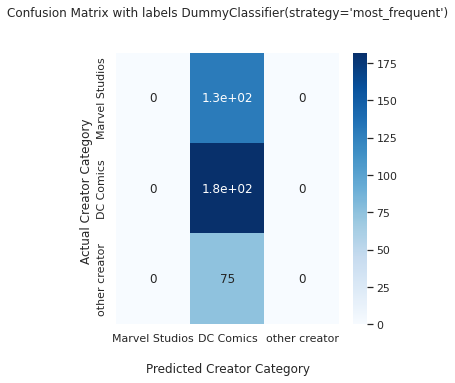

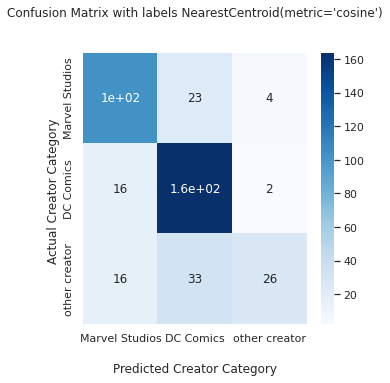

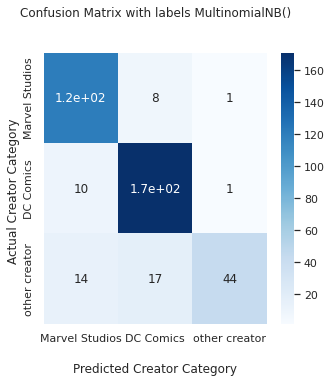

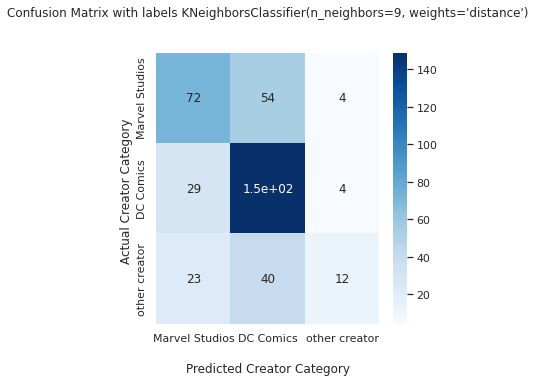

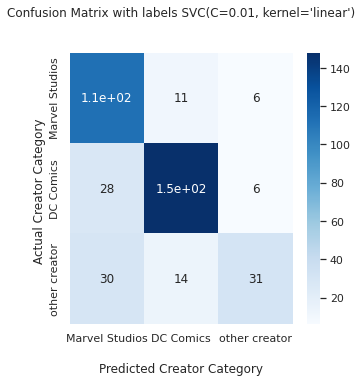

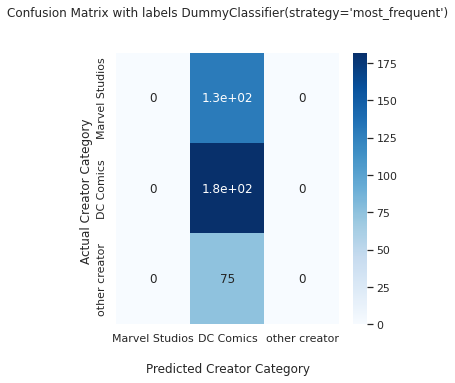

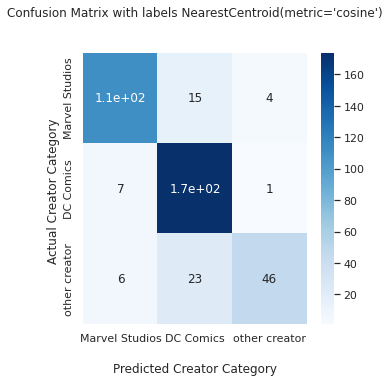

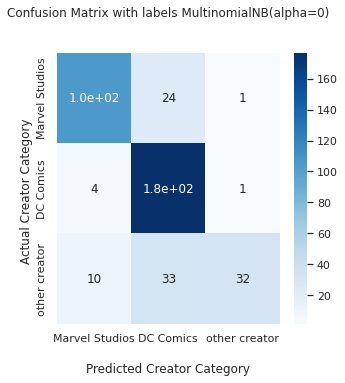

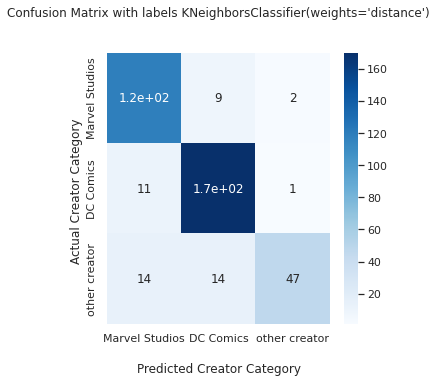

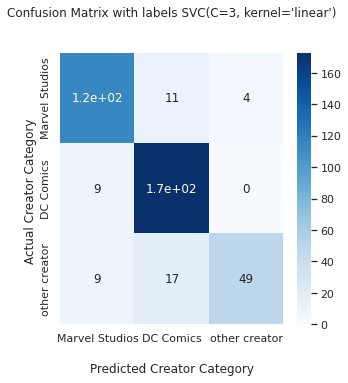

In [58]:
estimators_results = {}

for algortihm_with_parameters in gridsearch_result_only_count:
  checker = ModelClassification(algortihm_with_parameters, x_train, y_train, x_test, y_test)
  estimators_results['only counts ' + str(algortihm_with_parameters).split('(')[0]] = checker.classification_only_count()

for algortihm_with_parameters in gridsearch_result_count_tfidf: 
  checker = ModelClassification(algortihm_with_parameters, x_train, y_train, x_test, y_test)
  estimators_results['counts and tfidf ' + str(algortihm_with_parameters).split('(')[0]] = checker.classification_count_and_tfidf()

In the following block, the results of the classifier on the learning and test sets are presented. The quality measures used are:
- accuracy on the learning set and the test set,
- precision on the test set, the proportion of true positives
- effectiveness on the test set (recall), 
- f1-score, harmonic mean of sensitivity and precision. 
Additionally, the confusion matrices presented in the block above were generated. 

In [59]:
classification_result = pd.DataFrame.from_dict(estimators_results, orient='index')
classification_result

,train_set_accuracy,test_set_accuracy,precission,recall,f1-score
only counts DummyClassifier,0.4690,0.4703,0.2212,0.4703,0.3008
only counts NearestCentroid,0.8681,0.7571,0.7643,0.7571,0.7390
only counts MultinomialNB,0.9756,0.8682,0.8760,0.8682,0.8620
only counts KNeighborsClassifier,1.0000,0.6021,0.5997,0.6021,0.5692
only counts SVC,0.9523,0.7545,0.7640,0.7545,0.7462
counts and tfidf DummyClassifier,0.4690,0.4703,0.2212,0.4703,0.3008
counts and tfidf NearestCentroid,0.9922,0.8553,0.8615,0.8553,0.8505
counts and tfidf MultinomialNB,0.9989,0.8114,0.8345,0.8114,0.7973
counts and tfidf KNeighborsClassifier,1.0000,0.8682,0.8740,0.8682,0.8639
counts and tfidf SVC,0.9989,0.8708,0.8744,0.8708,0.8670


Analyzing the table presented above one can notice the following dependencies:
- for both sets of analyzed models the 'Dummy Classifier' has the worst accuracy, precision and efficiency
- models have a tendency to overfitting, the models for which the vector counting and transformation into tfidf matrix was carried out, than the vector counting alone. 
- For each of the sets, the precision, efficiency, and f1 score is maintained at a high level (around 0.8 - 0.9), and the data suggest that the models classify well into sets.

For the set whose predictors were subjected only to vectorization, the highest accuracy, efficiency and precision is achieved by Naive Bayes. 

For the set, which predictors were subjected to vectorization and conversion to frequency matrix classifiers showing similar transfereability.  

Analyzing confusion matrix it can be noticed that some of the observations are wrongly assigned to 'DC comics' category. The biggest problem classifiers had with assigning to set with other publishers, because descriptions could be much more differentiated.

#3. Information about words incidence in classes

In order to obtain information regarding the influence of individual words on classifications, a frequency study was conducted. In order to carry out the study, data preparation was required by merging previously divided sets into independent and dependent variables.

For the multi-class Naive Bayes classifier, a study of the direct effect of words on class assignment decisions was also conducted.

In [60]:
train_set = pd.concat([x_train, y_train.to_frame()], ignore_index=True, axis = 1) 
test_set = pd.concat([x_test, y_test.to_frame()], ignore_index=True, axis = 1) 

In [61]:
def check_frequency(check_set):
  column_names = pd.unique(check_set[1])
  df_result = pd.DataFrame()
  for column in column_names:
    grouped = check_set.groupby(check_set[1])
    df_new = grouped.get_group(column)

    tfIdfVectorizer=TfidfVectorizer(use_idf=True, stop_words = 'english')
    tfIdf = tfIdfVectorizer.fit_transform(df_new[0])
    df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    print(f'\n{column}')
    print(df.head(30) ) 

The frequencies of words in the train set

In [62]:
check_frequency(train_set)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Marvel Comics
             TF-IDF
hive       0.816691
parasites  0.250398
alveus     0.145886
host       0.116026
daniels    0.100560
body       0.091780
ward       0.080642
able       0.078152
memories   0.073432
malick     0.072943
inhuman    0.072516
maveth     0.068290
johnson    0.067484
daisy      0.054474
target     0.054365
hosts      0.049822
countless  0.049081
lucio      0.048629
bones      0.047109
managed    0.046945
inhumans   0.045961
parasitic  0.045527
grant      0.045427
kree       0.043510
reaper     0.043326
radcliffe  0.043326
possessed  0.042860
bodies     0.041868
jemma      0.041619
lash       0.041619

other creator
               TF-IDF
ren          0.416553
skywalker    0.359561
training     0.264785
endor        0.224946
kylo         0.208277
grandfather  0.196450
knights      0.196450
anakin       0.187276
youth        0.187276
luke         0.179781
solo         0.179781
ben          0.167954
uncle        0.163111
jedi         0.163111
begin        0.15878

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The frequencies of words in the test set

In [63]:
check_frequency(test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



other creator
               TF-IDF
hibernation  0.277971
derry        0.277971
murders      0.253668
event        0.223050
location     0.202882
series       0.161335
outwardly    0.138985
pattern      0.138985
cataclysmic  0.138985
asteroid     0.138985
maine        0.138985
awakening    0.138985
eat          0.138985
solved       0.138985
occurring    0.138985
27           0.138985
prevents     0.138985
adopted      0.138985
weather      0.126834
settled      0.126834
usual        0.126834
waking       0.126834
happen       0.126834
don          0.126834
explained    0.126834
deeply       0.126834
america      0.126834
north        0.118212
gruesome     0.118212
influence    0.118212


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Marvel Comics
                 TF-IDF
darwin         0.583323
alex           0.291661
erik           0.249746
shaw           0.194441
growing        0.146925
charles        0.131626
blast          0.123924
combusting     0.111192
partied        0.111192
gills          0.111192
bury           0.111192
submerged      0.111192
salvadore      0.111192
body           0.106842
adding         0.103019
avenged        0.103019
demise         0.103019
driver         0.103019
raven          0.103019
mutants        0.101615
tried          0.097773
taxi           0.097220
reaching       0.097220
sebastian      0.097220
cia            0.097220
spontaneously  0.092723
division       0.089048
aspects        0.085940
environment    0.085940
adapt          0.085940

DC Comics
                 TF-IDF
lagoon         0.430798
underwater     0.373174
teenager       0.373174
atlantis       0.373174
east           0.354624
titans         0.269029
originally     0.248136
boy            0.239378
joined        

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Analyzing the results presented above, it is noteworthy that in the set of the 'other creator' class the most frequent are words associated with the 'Lord of the Rings' universe and 'Star Wars'. In the 'Marvel Studio' class, the popularity of Spider-Man and the characteristic attributes in his comics (offices, pictures, boss) definitely shines through. For the 'DC Comics' class, a strong influence of the word 'imra' is noticeable, other words in the collection are definitely connected with a dark, polluted metropolis.

Information about the effect of variables on class assignment could only be obtained for naive Bayes. The results are included below. 

In [64]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=30):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print(classlabel, feat, coef)

In [65]:
word_vectorizer  = ColumnTransformer(
      [('vec', CountVectorizer(stop_words='english'), 'description')],  
      remainder='passthrough')
x_train_vectorized = word_vectorizer.fit_transform(x_train)

classifier = MultinomialNB()
classifier.fit(x_train_vectorized, y_train)

MultinomialNB()

In [66]:
# ['DC Comics', 'Marvel Studios', 'other creator']:
most_informative_feature_for_class(word_vectorizer, classifier, 'other creator')

other creator vec__shao -6.615381947653894
other creator vec__spider -6.605229576189877
other creator vec__battle -6.585228909483207
other creator vec__harry -6.585228909483207
other creator vec__like -6.555958527183094
other creator vec__master -6.527520591862561
other creator vec__ability -6.518218199200247
other creator vec__world -6.509001544095323
other creator vec__life -6.49986906053205
other creator vec__kahn -6.464150977929971
other creator vec__luke -6.446759235218102
other creator vec__new -6.404558880727725
other creator vec__powers -6.3640675193729885
other creator vec__dragon -6.34831916240485
other creator vec__later -6.2375047960645595
other creator vec__force -6.223615683903892
other creator vec__man -6.21674280461613
other creator vec__mario -6.150493419074929
other creator vec__akira -6.144103620976159
other creator vec__fight -6.118945061340003
other creator vec__form -6.070450711401393
other creator vec__saiyan -5.979993601246142
other creator vec__able -5.96390746

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


The results make it possible to see that the words 'spawn', 'earth', and 'human' have a large influence on the decision to assign the 'other creator' class. There are also single proper names such as: 'hellboy', 'akira', 'kale', 'saiyan', 'goku'.

# Classification of the primary set ('creator', 'description') with additional parameters

As for the earlier set, feature selection from the set, preprocessing, and splitting into a training set and a test set were performed.

In [67]:
choosen_parameters_names = ['creator', 'description','intelligence_score', 
                            'strength_score', 'speed_score', 'durability_score', 
                            'power_score', 'combat_score']

preprocesed_data = early_data_preprocessing(raw_data, choosen_parameters_names)

x_train, x_test, y_train, y_test = train_test_split(preprocesed_data[choosen_parameters_names[1:7]], preprocesed_data['creator'], test_size=0.3)

A search using the 'Gridsearch' function was performed to find the optimal hyperparameters for the classifiers.

In [68]:
gridsearch_result_only_count = []
gridsearch_result_count_tfidf = []

for algorithm, parameters in algorithms_and_parameters.items():
  checker = ModelCrossvalidation(algorithm, parameters, x_train, y_train)
  gridsearch_result_only_count.append(checker.crossvalidation_only_count())
  gridsearch_result_count_tfidf.append(checker.crossvalidation_count_and_tfdif())

print(f"Parametry dla zbioru poddanego jedynie wektoryzacji: \n"
f"{gridsearch_result_only_count}")
print(f"Parametry dla zbioru poddanego jedynie wektoryzacji i wyznaczeniu macierzy częstości: \n"
f"{gridsearch_result_count_tfidf}")

[Pipeline] .. (step 1 of 2) Processing vectorizer_count, total=   0.5s
[Pipeline] ........ (step 2 of 2) Processing gridsearch, total=   0.1s
[Pipeline] .. (step 1 of 3) Processing vectorizer_count, total=   0.6s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing gridsearch, total=   0.1s
[Pipeline] .. (step 1 of 2) Processing vectorizer_count, total=   0.6s
[Pipeline] ........ (step 2 of 2) Processing gridsearch, total=   2.5s
[Pipeline] .. (step 1 of 3) Processing vectorizer_count, total=   0.6s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing gridsearch, total=   2.5s
[Pipeline] .. (step 1 of 2) Processing vectorizer_count, total=   0.6s
[Pipeline] ........ (step 2 of 2) Processing gridsearch, total=   0.1s
[Pipeline] .. (step 1 of 3) Processing vectorizer_count, total=   0.6s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipel

The use of hyperparameters obtained by searching with the 'gridsearch' function.

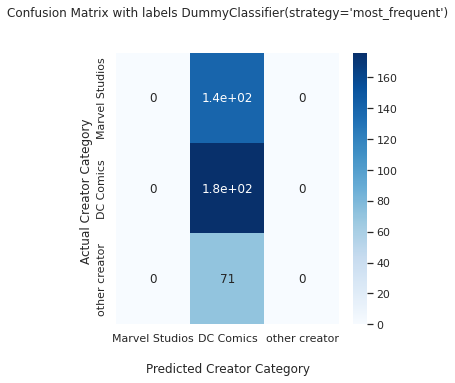

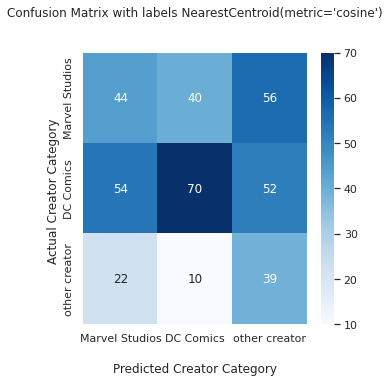

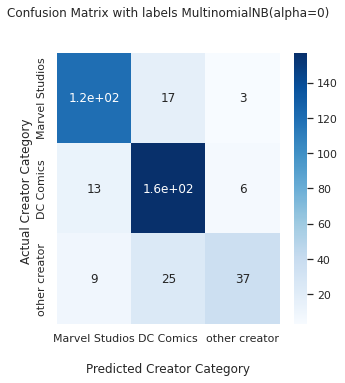

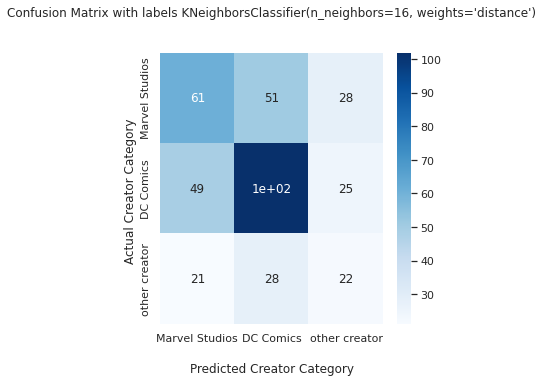

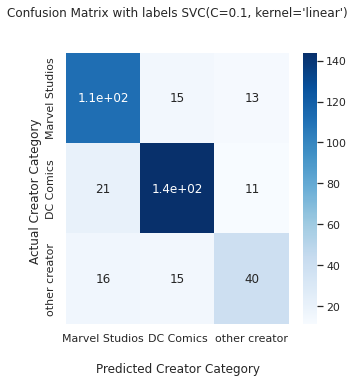

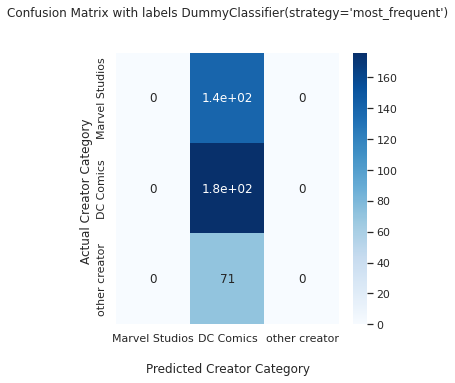

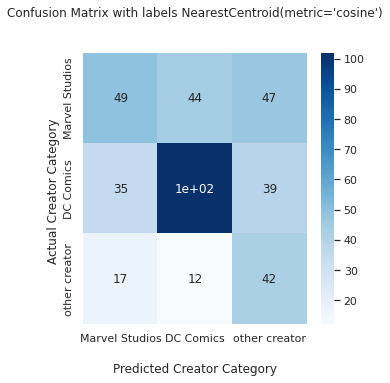

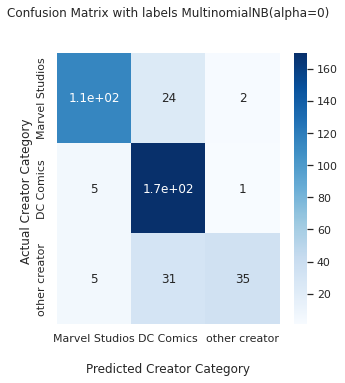

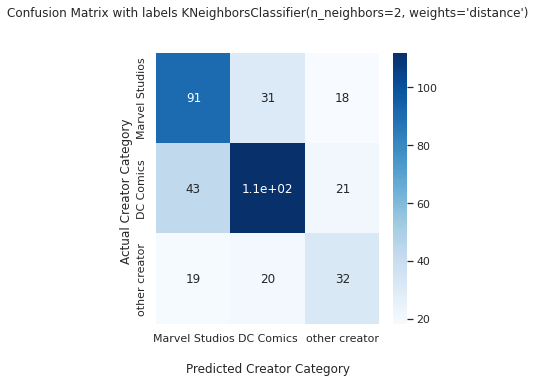

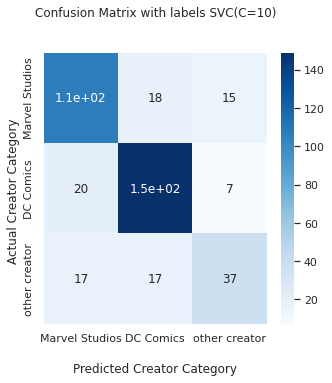

In [69]:
estimators_results = {}

for algortihm_with_parameters in gridsearch_result_only_count:
  checker = ModelClassification(algortihm_with_parameters, x_train, y_train, x_test, y_test)
  estimators_results['only counts ' + str(algortihm_with_parameters).split('(')[0]] = checker.classification_only_count()

for algortihm_with_parameters in gridsearch_result_count_tfidf: 
  checker = ModelClassification(algortihm_with_parameters, x_train, y_train, x_test, y_test)
  estimators_results['counts and tfidf ' + str(algortihm_with_parameters).split('(')[0]] = checker.classification_count_and_tfidf()

Analyzing the confusion matrix shown above, it can be seen that the least correct allocation to classes was made by models with the classifier "Dummy Classifier". In addition, a very bad allocation to classes was made by the classifier "Nearest Centroids" for the set processed using only the method "Count Vectorizer".

In [70]:
classification_with_additonal_data_results = pd.DataFrame.from_dict(estimators_results, orient= 'index')
classification_with_additonal_data_results

,train_set_accuracy,test_set_accuracy,precission,recall,f1-score
only counts DummyClassifier,0.4756,0.4548,0.2068,0.4548,0.2843
only counts NearestCentroid,0.4734,0.3953,0.4466,0.3953,0.4032
only counts MultinomialNB,0.9767,0.8114,0.8121,0.8114,0.8047
only counts KNeighborsClassifier,1.0000,0.4780,0.4786,0.4780,0.4780
only counts SVC,0.9978,0.7649,0.7630,0.7649,0.7633
counts and tfidf DummyClassifier,0.4756,0.4548,0.2068,0.4548,0.2843
counts and tfidf NearestCentroid,0.6475,0.4987,0.5293,0.4987,0.5023
counts and tfidf MultinomialNB,0.9967,0.8243,0.8452,0.8243,0.8158
counts and tfidf KNeighborsClassifier,1.0000,0.6072,0.6103,0.6072,0.6079
counts and tfidf SVC,0.9812,0.7571,0.7521,0.7571,0.7535


Analysis of results:
the results are worse than for the set with only descriptions. It is caused by introducing "noise" to the dataset. Additional features introduced to the set only for some of the observations were without any missing data. Improvement of classification quality could be achieved if features were correctly described and additionally normalized or scaled. 
In case of Naive Bayes, KNN and SVM we can observe very high additive fit mapped with high accuracy on the learning model. Comparing with the results on the test set and other measures, it can be seen that these models (especially KNN) have overfitted. Only Naive Bayes has satisfactory classification results, both for the set with only counted terms (vectors) and for the set with frequency matrix. 